# 1 Neural Networks
## 1.1 Visualizing the data

In [565]:
import numpy as np
import pandas as pd
from scipy.io import loadmat
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

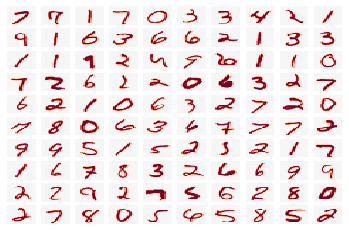

In [4]:
# Setup the parameters you will use for this exercise
input_layer_size  = 400;  # 20x20 Input Images of Digits
hidden_layer_size = 25;   # 25 hidden units
num_labels = 10;          # 10 labels, from 1 to 10   
                          # (note that we have mapped "0" to label 10)

## =========== Part 1: Loading and Visualizing Data =============
#  We start the exercise by first loading and visualizing the dataset. 
#  You will be working with a dataset that contains handwritten digits.

# Load Training Data
path = '/Users/jonathanbaker/Documents/Coding/Coursera/ML/machine-learning-ex4/ex4/'
data = loadmat(path + 'ex4data1.mat');

X = data.get('X')
y = data.get('y').flatten()
m = X.shape[0];

# Randomly select 100 data points to display
fig, axes = plt.subplots(10, 10)
for i in range(axes.shape[0]):
    for j in range(axes.shape[1]):
        sns.heatmap(X[np.random.randint(0, X.shape[0])].reshape([20, 20], order='F'), ax=axes[i, j]
                    , cbar=False, xticklabels=False, yticklabels=False)
        

In [566]:
# Relabel the 10's as 0's
y[y == 10] = 0

In [567]:
# OneHotEncode the y values
from sklearn.preprocessing import OneHotEncoder

binary_encoder = OneHotEncoder(sparse=False)
y_ = binary_encoder.fit_transform(y.reshape(-1, 1))

y_.shape

(5000, 10)

In [568]:
binary_encoder.active_features_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [569]:
y_[0]

array([ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.])

Converting 10's to 0's first then OneHotEncoding has put 0 labels first (i.e. first column denotes 0), rather than 10 labels last. Need to flip the first column to the end so last column denotes 0 (0=10 in the original documentation):

In [570]:
y_ = np.column_stack((y_[:, 1:], y_[:, 0]))

In [571]:
y_[0]

array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.])

In [572]:
y_.shape

(5000, 10)

## 1.2 Model representation

In [573]:
## ================ Part 2: Loading Parameters ================
# In this part of the exercise, we load some pre-initialized 
# neural network parameters.
# Load the weights into variables Theta1 and Theta2

weights = loadmat(path + 'ex4weights.mat');

Theta1 = weights.get('Theta1')
Theta2 = weights.get('Theta2')


In [574]:
Theta1.flatten().shape

(10025,)

In [575]:
nn_params = np.concatenate((Theta1.flatten(), Theta2.flatten()))

In [576]:
Theta1

array([[ -2.25623899e-02,  -1.05624163e-08,   2.19414684e-09, ...,
         -1.30529929e-05,  -5.04175101e-06,   2.80464449e-09],
       [ -9.83811294e-02,   7.66168682e-09,  -9.75873689e-09, ...,
         -5.60134007e-05,   2.00940969e-07,   3.54422854e-09],
       [  1.16156052e-01,  -8.77654466e-09,   8.16037764e-09, ...,
         -1.20951657e-04,  -2.33669661e-06,  -7.50668099e-09],
       ..., 
       [ -1.83220638e-01,  -8.89272060e-09,  -9.81968100e-09, ...,
          2.35311186e-05,  -3.25484493e-06,   9.02499060e-09],
       [ -7.02096331e-01,   3.05178374e-10,   2.56061008e-09, ...,
         -8.61759744e-04,   9.43449909e-05,   3.83761998e-09],
       [ -3.50933229e-01,   8.85876862e-09,  -6.57515140e-10, ...,
         -1.80365926e-06,  -8.14464807e-06,   8.79454531e-09]])

## 1.3 Feedforward and cost function

In [577]:
## ================ Part 3: Compute Cost (Feedforward) ================
#  To the neural network, you should first start by implementing the
#  feedforward part of the neural network that returns the cost only. You
#  should complete the code in nnCostFunction.m to return cost. After
#  implementing the feedforward to compute the cost, you can verify that
#  your implementation is correct by verifying that you get the same cost
#  as us for the fixed debugging parameters.
#
#  We suggest implementing the feedforward cost *without* regularization
#  first so that it will be easier for you to debug. Later, in part 4, you
#  will get to implement the regularized cost.
#

In [578]:
def sigmoid(z):
    
    return 1 / (1 + np.exp(-z))

In [579]:
def addInterceptCol(X):
    
    if len(X.shape) > 1:
        m = X.shape[0]
        
        return np.column_stack( (np.ones(m), X) )

    else:
        return np.concatenate( (np.ones(1), X) )

In [580]:
def nnFeedForward(theta, a_in):
    """
    Calculates single layer output activations given parameters (theta) and input (a)
    """
    # Set up some useful variables    
    z_out = addInterceptCol(a_in).dot(theta.transpose())
    act_out = sigmoid(z_out)
    
    return act_out
    

In [706]:
# Cost function without regulatization

def nnCostFunction(nn_params, input_layer_size, hidden_layer_size, num_labels, X, y, Lambda):
    """
    NNCOSTFUNCTION Implements the neural network cost function for a two layer
    neural network which performs classification
       J = NNCOSTFUNCTON(nn_params, hidden_layer_size, num_labels, X, y, lambda) 
       computes the cost and gradient of the neural network. The
       parameters for the neural network are "unrolled" into the vector
       nn_params and need to be converted back into the weight matrices. 
    
       The returned parameter grad should be a "unrolled" vector of the
       partial derivatives of the neural network.
       
       Note: Unlike Andrew Ng's implementation, the y input needs to be one hot encoded labels!
    """
    
    # Reshape nn_params back into the parameters Theta1 and Theta2, the weight matrices
    # for our 2 layer neural network
    Theta1 = nn_params[0:((input_layer_size + 1) * hidden_layer_size)].reshape((hidden_layer_size, input_layer_size + 1))
    Theta2 = nn_params[((input_layer_size + 1) * hidden_layer_size):].reshape((num_labels, hidden_layer_size + 1))
    
    # Set up some useful variables
    m = X.shape[0]
    
    # Part 1: Feedforward the neural network and return the cost in the
    #         variable J. After implementing Part 1, you can verify that your
    #         cost function computation is correct by verifying the cost
    #         computed in ex4.m
    act1 = nnFeedForward(Theta1, X)
    act2 = nnFeedForward(Theta2, act1)
    y_hat = act2
    
    J = - (  np.sum(y * np.log(y_hat)) + np.sum((1-y) * np.log(1 - y_hat))  ) / m
    
    return J

In [582]:
# Weight regularization parameter (we set this to 0 here).
Lambda = 0;

J = nnCostFunction(nn_params, input_layer_size, hidden_layer_size, num_labels, X, y_, Lambda);

print('Cost at parameters (loaded from ex4weights): {}'.format(J))
print('(this value should be about 0.287629)\n');


Cost at parameters (loaded from ex4weights): 0.28762916516131887
(this value should be about 0.287629)



In [583]:
## =============== Part 4: Implement Regularization ===============
#  Once your cost function implementation is correct, you should now
#  continue to implement the regularization with the cost.

In [707]:
# Cost function with regularization

def nnCostFunctionReg(nn_params, input_layer_size, hidden_layer_size, num_labels, X, y, Lambda):
    """
    NNCOSTFUNCTION Implements the neural network cost function for a two layer
    neural network which performs classification
       J = NNCOSTFUNCTON(nn_params, hidden_layer_size, num_labels, X, y, lambda) 
       computes the cost and gradient of the neural network. The
       parameters for the neural network are "unrolled" into the vector
       nn_params and need to be converted back into the weight matrices. 
    
       The returned parameter grad should be a "unrolled" vector of the
       partial derivatives of the neural network.
       
       Note: Unlike Andrew Ng's implementation, the y input needs to be one hot encoded labels!

    """
    
    # Reshape nn_params back into the parameters Theta1 and Theta2, the weight matrices
    # for our 2 layer neural network
    Theta1 = nn_params[0:((input_layer_size + 1) * hidden_layer_size)].reshape((hidden_layer_size, input_layer_size + 1))
    Theta2 = nn_params[((input_layer_size + 1) * hidden_layer_size):].reshape((num_labels, hidden_layer_size + 1))
    
    # Set up some useful variables
    m = X.shape[0]
    
    # Part 1: Feedforward the neural network and return the cost in the
    #         variable J. After implementing Part 1, you can verify that your
    #         cost function computation is correct by verifying the cost
    #         computed in ex4.m
    act1 = nnFeedForward(Theta1, X)
    act2 = nnFeedForward(Theta2, act1)
    
    y_hat = act2

    reg = Lambda * np.sum([np.sum(Theta1[:, 1:]**2), np.sum(Theta2[:, 1:]**2)]) / (2*m)
    
    J = - (  np.sum(y * np.log(y_hat)) + np.sum((1-y) * np.log(1 - y_hat))  ) / m + reg
    
    return J

In [585]:
print('Checking Cost Function (with Regularization)... \n')

# Weight regularization parameter (we set this to 1 here).
Lambda = 1;

J = nnCostFunctionReg(nn_params, input_layer_size, hidden_layer_size, num_labels, X, y_, Lambda);

print('Cost at parameters (loaded from ex4weights): {}'.format(J))
print('(this value should be about 0.383770)\n');

Checking Cost Function (with Regularization)... 

Cost at parameters (loaded from ex4weights): 0.3837698590909236
(this value should be about 0.383770)



# 2 Backpropagation
## 2.1 Sigmoid Gradient

In [586]:
## ================ Part 5: Sigmoid Gradient  ================
#  Before you start implementing the neural network, you will first
#  implement the gradient for the sigmoid function. You should complete the
#  code in the sigmoidGradient.m file.
#

In [587]:
def sigmoidGradient(z):
    """    
        SIGMOIDGRADIENT returns the gradient of the sigmoid function
        evaluated at z
        g = SIGMOIDGRADIENT(z) computes the gradient of the sigmoid function
        evaluated at z. This should work regardless if z is a matrix or a
        vector. In particular, if z is a vector or matrix, you should return
        the gradient for each element.
    """

    # Compute the gradient of the sigmoid function evaluated at
    # each value of z (z can be a matrix, vector or scalar).

    return sigmoid(z) * (1 - sigmoid(z))


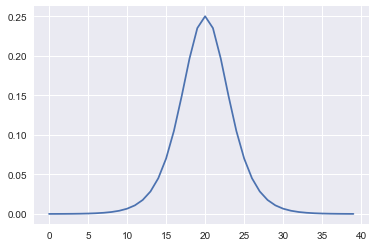

In [588]:
plt.plot(sigmoidGradient(np.arange(-10, 10, 0.5)))

In [589]:
print('Sigmoid gradient evaluated at [-1 -0.5 0 0.5 1]:');
sigmoidGradient(np.array([-1, -0.5, 0, 0.5, 1]))

Sigmoid gradient evaluated at [-1 -0.5 0 0.5 1]:


array([ 0.19661193,  0.23500371,  0.25      ,  0.23500371,  0.19661193])

## 2.2 Random Initialization

In [590]:
## ================ Part 6: Initializing Pameters ================
#  In this part of the exercise, you will be starting to implment a two
#  layer neural network that classifies digits. You will start by
#  implementing a function to initialize the weights of the neural network
#  (randInitializeWeights.m)

In [591]:
def randInitializeWeights(L_in, L_out):
    
    return np.random.uniform(-0.12, 0.12, size=(L_in + 1)* L_out).reshape((L_in + 1), L_out)

In [592]:
randInitializeWeights(1, 2)

array([[ 0.03618875, -0.07328334],
       [ 0.09919629, -0.00944799]])

In [593]:
initial_Theta1 = randInitializeWeights(input_layer_size, hidden_layer_size);
initial_Theta2 = randInitializeWeights(hidden_layer_size, num_labels);

# Unroll parameters
initial_nn_params = np.concatenate((initial_Theta1.flatten(), initial_Theta2.flatten()));

## 2.3 Backpropagation

In [594]:
## =============== Part 7: Implement Backpropagation ===============
#  Once your cost matches up with ours, you should proceed to implement the
#  backpropagation algorithm for the neural network. You should add to the
#  code you've written in nnCostFunction.m to return the partial
#  derivatives of the parameters.
#

In [786]:
def nnGradients(nn_params, input_layer_size, hidden_layer_size, num_labels, X, y, Lambda):
    
    Theta1 = nn_params[0:(input_layer_size + 1) * hidden_layer_size].reshape((hidden_layer_size, input_layer_size + 1))
    Theta2 = nn_params[(input_layer_size + 1) * hidden_layer_size:].reshape((num_labels, hidden_layer_size + 1))
    m = X.shape[0]
    #X = addInterceptCol(X)
    
    Theta1_grad = np.zeros(Theta1.shape) # This was incorrect: (input_layer_size, hidden_layer_size))
    Theta2_grad = np.zeros(Theta2.shape) # This was incorrect: (hidden_layer_size, num_labels))
    
    # Feedforward:   
    a1 = addInterceptCol(X)
    
    z2 = a1.dot(Theta1.transpose())
    a2 = sigmoid(z2)
    a2 = addInterceptCol(a2)
    
    z3 = a2.dot(Theta2.transpose())
    a3 = sigmoid(z3)

    delta3 = a3 - y
    delta2 = delta3.dot(Theta2[:, 1:]) * sigmoidGradient(z2) # careful of slicing placement. Slicing weights
    
    # Taking dot product faster than looping through all m training examples
    Theta1_grad = Theta1_grad + delta2.transpose().dot(a1)
    Theta2_grad = Theta2_grad + delta3.transpose().dot(a2)
    
    grad = (np.concatenate([Theta1_grad.flatten(), Theta2_grad.flatten()]) + Lambda * nn_params) / m
    
    return grad

In [790]:
nnGradients(nn_params, input_layer_size, hidden_layer_size, num_labels, X, y_, 0)

array([  6.18712766e-05,   0.00000000e+00,   0.00000000e+00, ...,
         9.66104721e-05,  -7.57736846e-04,   7.73329872e-04])

In [791]:
nnFeedForward(Theta2, nnFeedForward(Theta1, X)).shape

(5000, 10)

In [792]:
def debugInitializeWeights(fan_out, fan_in):
    """    
    DEBUGINITIALIZEWEIGHTS Initialize the weights of a layer with fan_in
    incoming connections and fan_out outgoing connections using a fixed
    strategy, this will help you later in debugging
       W = DEBUGINITIALIZEWEIGHTS(fan_in, fan_out) initializes the weights 
       of a layer with fan_in incoming connections and fan_out outgoing 
       connections using a fix set of values
    
       Note that W should be set to a matrix of size(1 + fan_in, fan_out) as
       the first row of W handles the "bias" terms
    """

    # Set W to zeros
    W = np.zeros((fan_out, 1 + fan_in));

    # Initialize W using "sin", this ensures that W is always of the same
    # values and will be useful for debugging
    W = np.sin(np.arange(0, W.size)).reshape(W.shape) / 10;

    # =========================================================================

    return W

In [793]:
debugInitializeWeights(3,3)

array([[ 0.        ,  0.0841471 ,  0.09092974,  0.014112  ],
       [-0.07568025, -0.09589243, -0.02794155,  0.06569866],
       [ 0.09893582,  0.04121185, -0.05440211, -0.09999902]])

In [794]:
def computeNumericalGradient(theta, input_layer_size, hidden_layer_size, num_labels, X, y, Lambda):
    """
        COMPUTENUMERICALGRADIENT Computes the gradient using "finite differences"
        and gives us a numerical estimate of the gradient.
        numgrad = COMPUTENUMERICALGRADIENT(J, theta) computes the numerical
        gradient of the function J around theta. Calling y = J(theta) should
        return the function value at theta.

     Notes: The following code implements numerical gradient checking, and 
            returns the numerical gradient.It sets numgrad(i) to (a numerical 
            approximation of) the partial derivative of J with respect to the 
            i-th input argument, evaluated at theta. (i.e., numgrad(i) should 
            be the (approximately) the partial derivative of J with respect 
            to theta(i).)    
    """           

    numgrad = np.zeros(theta.shape);
    perturb = np.zeros(theta.shape);
    e = 1e-4;
    for p in range(theta.size):
        # Set perturbation vector
        perturb[p] = e;
        loss1 = nnCostFunction(theta - perturb, input_layer_size, hidden_layer_size, num_labels, X, y, Lambda);
        loss2 = nnCostFunction(theta + perturb, input_layer_size, hidden_layer_size, num_labels, X, y, Lambda)
        # Compute Numerical Gradient
        numgrad[p] = (loss2 - loss1) / (2*e);
        perturb[p] = 0;

    return numgrad


In [802]:
def checkNNGradients(Lambda=0):
    """
    CHECKNNGRADIENTS Creates a small neural network to check the
    backpropagation gradients
       CHECKNNGRADIENTS(lambda) Creates a small neural network to check the
       backpropagation gradients, it will output the analytical gradients
       produced by your backprop code and the numerical gradients (computed
       using computeNumericalGradient). These two gradient computations should
       result in very similar values.
    """

    input_layer_size = 3;
    hidden_layer_size = 5;
    num_labels = 3;
    m = 5;

    # We generate some 'random' test data
    Theta1 = debugInitializeWeights(hidden_layer_size, input_layer_size);
    Theta2 = debugInitializeWeights(num_labels, hidden_layer_size);
    #return Theta1, Theta2
    
    # Reusing debugInitializeWeights to generate X
    X  = debugInitializeWeights(m, input_layer_size - 1);
    y  = 1 + np.mod(np.arange(1, m+1), num_labels).transpose();
    #return X, y

    # Bit of hack to make the code work. OneHotEncode y here
    from sklearn.preprocessing import OneHotEncoder
    binary_encoder = OneHotEncoder(sparse=False)
    y_ = binary_encoder.fit_transform(y.reshape(-1, 1))

    # Unroll parameters
    nn_params = np.concatenate((Theta1.flatten(), Theta2.flatten()));
    #return nn_params # Debugging
    
    # Cost function  
    cost = nnCostFunction(nn_params, input_layer_size, hidden_layer_size, num_labels, X, y_, Lambda);
    grad = nnGradients(nn_params, input_layer_size, hidden_layer_size, num_labels, X, y_, Lambda);
    numgrad = computeNumericalGradient(nn_params, input_layer_size, hidden_layer_size, num_labels, X, y_, Lambda);
    #return numgrad.shape, grad.shape # Debugging
    
    # Visually examine the two gradient computations.  The two columns
    # you get should be very similar. 
    print(np.column_stack((numgrad, grad)));
    print('The above two columns you get should be very similar.\n' \
            '(Left-Your Numerical Gradient, Right-Analytical Gradient)\n\n');

    # Evaluate the norm of the difference between two solutions.  
    # If you have a correct implementation, and assuming you used EPSILON = 0.0001 
    # in computeNumericalGradient.m, then diff below should be less than 1e-9
    # Note octave norm is Euclidean distance (p=2 norm)
    diff = np.linalg.norm(numgrad-grad, 2)/np.linalg.norm(numgrad+grad, 2);

    print('If your backpropagation implementation is correct, then \n' \
             'the relative difference will be small (less than 1e-9). \n' \
             '\nRelative Difference: {}\n'.format(diff));



In [801]:
print('\nChecking Backpropagation... \n');

#  Check gradients by running checkNNGradients
#tmp1, tmp2 = checkNNGradients() # Debug
checkNNGradients()


Checking Backpropagation... 

[[  9.01303866e-03   9.01303866e-03]
 [ -6.08047124e-05  -6.08047127e-05]
 [ -6.96666280e-06  -6.96665817e-06]
 [  5.32765099e-05   5.32765097e-05]
 [  1.17193332e-02   1.17193332e-02]
 [ -7.05495395e-05  -7.05495376e-05]
 [  1.66652194e-04   1.66652194e-04]
 [  2.50634669e-04   2.50634667e-04]
 [  3.66087511e-03   3.66087511e-03]
 [ -1.54510227e-05  -1.54510225e-05]
 [  1.86817173e-04   1.86817175e-04]
 [  2.17326526e-04   2.17326523e-04]
 [ -7.76550108e-03  -7.76550109e-03]
 [  5.38947953e-05   5.38947948e-05]
 [  3.53029184e-05   3.53029178e-05]
 [ -1.57463020e-05  -1.57462990e-05]
 [ -1.20637760e-02  -1.20637760e-02]
 [  7.36352002e-05   7.36351996e-05]
 [ -1.48712775e-04  -1.48712777e-04]
 [ -2.34334914e-04  -2.34334912e-04]
 [  3.02286353e-01   3.02286353e-01]
 [  1.51010770e-01   1.51010770e-01]
 [  1.45233242e-01   1.45233242e-01]
 [  1.58998192e-01   1.58998192e-01]
 [  1.46779086e-01   1.46779086e-01]
 [  1.48987769e-01   1.48987769e-01]
 [  9.9

In [621]:
## =============== Part 8: Implement Regularization ===============
#  Once your backpropagation implementation is correct, you should now
#  continue to implement the regularization with the cost and gradient.